In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from pandas.tools.plotting import parallel_coordinates

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.stats import chisquare,ttest_ind
from scipy import stats

from matplotlib.ticker import FormatStrFormatter

## Load Data:

In [2]:
# CLIMATE DAU 
partida_dau = pd.read_csv("dades/dades_csv/climatedau/game_partida.csv", delimiter=',' , encoding="latin-1")
ronda_dau = pd.read_csv("dades/dades_csv/climatedau/game_ronda.csv", delimiter=',' , encoding="latin-1")
user_dau = pd.read_csv("dades/dades_csv/climatedau/game_user.csv", delimiter=',' , encoding="latin-1")

user_dau.drop(user_dau.index[3], inplace=True)
userronda_dau = pd.read_csv("dades/dades_csv/climatedau/game_userronda.csv", delimiter=',' , encoding="latin-1")

eq_user_dau = pd.read_csv("dades/eq_user_dau.csv", delimiter=',' , encoding="latin-1")
ineq_user_dau = user_dau[~user_dau.user_id.isin(eq_user_dau['user_id'])]

# CLIMATE STREET 
partida_street = pd.read_csv("dades/dades_csv/climatestreet/game_partida_street.csv", delimiter=',' , encoding="latin-1")
ronda_street = pd.read_csv("dades/dades_csv/climatestreet/game_ronda_street.csv", delimiter=',' , encoding="latin-1")
user_street = pd.read_csv("dades/dades_csv/climatestreet/game_user_street.csv", delimiter=',' , encoding="latin-1")
user_street.drop(user_street[user_street['diners_inicials']== 0].index, inplace=True)
userronda_street = pd.read_csv("dades/dades_csv/climatestreet/game_userronda_street.csv", delimiter=',' , encoding="latin-1")

# CLIMATE VIL
partida_vil = pd.read_csv("dades/dadesvil/partida.csv", delimiter=',' , encoding="latin-1")
ronda_vil = pd.read_csv("dades/dadesvil/ronda.csv", delimiter=',' , encoding="latin-1")
user_vil = pd.read_csv("dades/dadesvil/user.csv", delimiter=',' , encoding="latin-1")
user_vil.drop(user_vil[user_vil['diners_inicials']== 0].index, inplace=True)
userronda_vil = pd.read_csv("dades/dadesvil/userronda.csv", delimiter=',' , encoding="latin-1")

user_street.rename(columns={'id': 'user_id'}, inplace=True)
user_vil.rename(columns={'id': 'user_id'}, inplace=True)

In [3]:
user_het=pd.concat([ineq_user_dau.loc[:,['user_id','diners_inicials']],user_street.loc[:,['user_id','diners_inicials']]])
user_hom=pd.concat([eq_user_dau.loc[:,['user_id','diners_inicials']],user_vil.loc[:,['user_id','diners_inicials']]])

In [4]:
def contribution_round(user, userronda, norm):
    tonorm = user[['user_id','diners_inicials']]
    tocontr = pd.merge(userronda,tonorm, on = 'user_id')
    #Normalization
    tocontr['selnorm'] = (tocontr['seleccio']/tocontr['diners_inicials'])*10
    rondes = np.arange(1,11)
    ronda_id = np.tile(rondes,len(np.unique(userronda['user_id']))) #324 users
    tocontr['ronda_id'] = ronda_id
    contr_round = pd.pivot(index = tocontr['user_id'], columns = tocontr['ronda_id'], values = tocontr[norm])
    return contr_round

In [5]:
# Normalized contributions per round
## DAU
contr_dau_norm = contribution_round(user_dau,userronda_dau, 'selnorm')
contr_dau = contribution_round(user_dau,userronda_dau, 'seleccio')

## DAU eq: 
eq_dau = pd.read_csv("dades/eq_dau.csv", delimiter=',' , encoding="latin-1")
eq_contr_dau = eq_dau.iloc[:,2:12]
eq_contr_dau = eq_contr_dau.set_index(eq_user_dau.user_id)
eq_contr_dau_norm = contr_dau_norm[contr_dau_norm.index.isin(eq_dau['user_id'])]
namesList = [np.linspace(1,10,10,dtype=int)]
eq_contr_dau.columns = namesList
eq_contr_dau_norm.columns = namesList

## DAU ineq:
ineq_dau = pd.read_csv("dades/ineq_dau.csv", delimiter=',' , encoding="latin-1")
ineq_contr_dau = ineq_dau.iloc[:,2:12]
ineq_contr_dau = ineq_contr_dau.set_index(ineq_user_dau.user_id)
ineq_contr_dau_norm = contr_dau_norm[contr_dau_norm.index.isin(ineq_dau['user_id'])]
ineq_contr_dau.columns = namesList
ineq_contr_dau_norm.columns = namesList

## STREET
contr_street_norm = contribution_round(user_street,userronda_street, 'selnorm')
contr_street = contribution_round(user_street,userronda_street, 'seleccio')

## VIL
contr_vil_norm = contribution_round(user_vil,userronda_vil, 'selnorm')
contr_vil = contribution_round(user_vil,userronda_vil, 'seleccio')

In [6]:
### Ronda 0: 
ronda_dau0 = pd.read_csv("dades/ronda_dau_0.csv", delimiter=',' , encoding="latin-1")
ronda_street0 = pd.read_csv("dades/ronda_street_0.csv", delimiter=',' , encoding="latin-1")
ronda_vil0 = pd.read_csv("dades/ronda_vil_0.csv", delimiter=',' , encoding="latin-1")

In [7]:
daur = pd.read_csv("dades/dau_r.csv", delimiter=',' , encoding="latin-1")
streetr = pd.read_csv("dades/street_r.csv", delimiter=',' , encoding="latin-1")
vilr = pd.read_csv("dades/vil_r.csv", delimiter=',' , encoding="latin-1")

In [8]:
def dataset_2(ds_r,user_ds):
    table1 = ds_r[['user_id','partida_id','mean_contr']]
    table2 = user_ds[['user_id', 'genere', 'rang_edat','prfinal1','prfinal2','prfinal3','prfinal4','prfinal5','prfinal6',
                     'prfinal7','prfinal8','prfinal9','prfinal10','prfinal11','prfinal12','prfinal13','prfinal14','prfinal15']]
    ds_2 = table1.merge(table2, on = 'user_id')
    ds_2['genere'] =ds_2['genere'].map({'d': 1, 'h': 0})
    ds_2['prfinal1'] =ds_2['prfinal1'].map({'r1': 1, 'r2': 2, 'r3':3, 'nan':0})
    ds_2['prfinal2'] =ds_2['prfinal2'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal3'] =ds_2['prfinal3'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal4'] =ds_2['prfinal4'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal5'] =ds_2['prfinal5'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal6'] =ds_2['prfinal6'].map({'r1': 1, 'r2': 2, 'r3':3,'nan':0})
    ds_2['prfinal7'] =ds_2['prfinal7'].map({'r1': 1, 'r2': 2, 'r3':3,'nan':0})
    ds_2['prfinal8'] =ds_2['prfinal8'].map({'r1': 1, 'r2': 2, 'r3':3,'nan':0})
    ds_2['prfinal9'] =ds_2['prfinal9'].map({'r1': 1, 'r2': 2, 'r3':3,'nan':0})
    ds_2['prfinal10'] =ds_2['prfinal10'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal11'] =ds_2['prfinal11'].map({'r1': 1, 'r4': 3, 'r3':2,'nan':0})
    ds_2['prfinal12'] =ds_2['prfinal12'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal13'] =ds_2['prfinal13'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal14'] =ds_2['prfinal14'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    ds_2['prfinal15'] =ds_2['prfinal15'].map({'r1': 1, 'r2': 2, 'r3':3, 'r4':4,'nan':0})
    return(ds_2)

In [9]:
ds_2_dau = dataset_2(daur,user_dau)
ds_2_street = dataset_2(streetr,user_street)

user_vil.rename(columns={'enquesta_final_pr1': 'prfinal1', 'enquesta_final_pr2': 'prfinal2','enquesta_final_pr3': 'prfinal3',
                        'enquesta_final_pr4': 'prfinal4','enquesta_final_pr5': 'prfinal5','enquesta_final_pr6': 'prfinal6',
                        'enquesta_final_pr7': 'prfinal7','enquesta_final_pr8': 'prfinal8','enquesta_final_pr9': 'prfinal9',
                        'enquesta_final_pr10': 'prfinal10','enquesta_final_pr11': 'prfinal11','enquesta_final_pr12': 'prfinal12',
                        'enquesta_final_pr13': 'prfinal13',}, inplace=True)

table1 = vilr[['user_id','partida_id','mean_contr']]
table2 = user_vil[['user_id', 'genere', 'rang_edat','prfinal1','prfinal2','prfinal3','prfinal4','prfinal5','prfinal6',
                 'prfinal7','prfinal8','prfinal9','prfinal10','prfinal11','prfinal12','prfinal13']]
ds_2_vil = table1.merge(table2, on = 'user_id')
ds_2_vil['genere'] =ds_2_vil['genere'].map({'F': 1, 'M': 0})

#create new df 
final_dau = pd.DataFrame({'ronda_obj':ronda_dau0.groupby('partida_id').last()['num_ronda'],
                            'partida_id':np.unique(ronda_dau0['partida_id'])})

final_street = pd.DataFrame({'ronda_obj':ronda_street0.groupby('partida_id').last()['num_ronda'],
                            'partida_id':np.unique(ronda_street0['partida_id'])})

final_vil = pd.DataFrame({'ronda_obj':ronda_vil0.groupby('partida_id').last()['num_ronda'],
                            'partida_id':np.unique(ronda_vil0['partida_id'])})
#print (df)

ronda_dau_data = pd.read_csv("dades/ronda_dau_partida.csv", delimiter=',' , encoding="latin-1")
ronda_street_data = pd.read_csv("dades/ronda_street_partida.csv", delimiter=',' , encoding="latin-1")
ronda_vil_data = pd.read_csv("dades/ronda_vil_partida.csv", delimiter=',' , encoding="latin-1")

partides_info_dau = ronda_dau_data.pivot(index='partida_id', columns='num_ronda', values= "bucket")
partides_info_street = ronda_street_data.pivot(index='partida_id', columns='num_ronda', values= "bucket")
partides_info_vil = ronda_vil_data.pivot(index='partida_id', columns='num_ronda', values= "bucket")

#ineq_contr_dau_norm.to_csv('dades/ineq_contr_dau_norm.csv', sep=',')
#eq_contr_dau_norm.to_csv('dades/eq_contr_dau_norm.csv', sep=',')
#contr_street_norm.to_csv('dades/contr_street_norm.csv', sep=',')
#contr_vil_norm.to_csv('dades/contr_vil_norm.csv', sep=',')

In [10]:
## Datasets: Heterogeneous, Homogeneous, Heterogeneous norm, Homogeneous norm
ineq_contr_dau_2= ineq_contr_dau.assign(experiment='het_dau')
contr_street_2= contr_street.assign(experiment='street')
frames_het = [ineq_contr_dau_2, contr_street_2]
heterogeneous = pd.concat(frames_het)

eq_contr_dau_2= eq_contr_dau.assign(experiment='hom_dau')
contr_vil_2= contr_vil.assign(experiment='vil')
frames_hom = [eq_contr_dau_2, contr_vil_2]
homogeneous = pd.concat(frames_hom)

ineq_contr_dau_2= ineq_contr_dau_norm.assign(experiment='het_dau')
contr_street_2= contr_street_norm.assign(experiment='street')
frames_het = [ineq_contr_dau_2, contr_street_2]
heterogeneous_norm = pd.concat(frames_het)

eq_contr_dau_2= eq_contr_dau_norm.assign(experiment='hom_dau')
contr_vil_2= contr_vil_norm.assign(experiment='vil')
frames_hom = [eq_contr_dau_2, contr_vil_2]
homogeneous_norm = pd.concat(frames_hom)

In [11]:
##Standarize data: 
##Standarize normalized contributions
#from sklearn.preprocessing import StandardScaler
#X = heterogeneous_norm.iloc[:,:10]
##Standarize
#X = StandardScaler().fit_transform(X)
#heterogeneous_norm = pd.DataFrame(X, index = heterogeneous_norm.index)
#
#Y = homogeneous_norm.iloc[:,:10]
##Standarize
#Y = StandardScaler().fit_transform(Y)
#homogeneous_norm = pd.DataFrame(Y, index = homogeneous_norm.index)
#
#
##For Datasets: 
#
#contr_street_norm = pd.DataFrame(StandardScaler().fit_transform(contr_street_norm), index = contr_street_norm.index)
#contr_vil_norm = pd.DataFrame(StandardScaler().fit_transform(contr_vil_norm), index = contr_vil_norm.index)
#eq_contr_dau_norm = pd.DataFrame(StandardScaler().fit_transform(eq_contr_dau_norm), index = eq_contr_dau_norm.index)
#ineq_contr_dau_norm = pd.DataFrame(StandardScaler().fit_transform(ineq_contr_dau_norm), index = ineq_contr_dau_norm.index)
#
#
#namesList = [np.linspace(1,10,10,dtype=int)]
#heterogeneous_norm.columns = namesList
#homogeneous_norm.columns = namesList
#contr_street_norm.columns = namesList
#contr_vil_norm.columns = namesList
#eq_contr_dau_norm.columns = namesList
#ineq_contr_dau_norm.columns = namesList

In [12]:
## Took from: https://stackoverflow.com/questions/35611465/python-scikit-learn-clustering-with-missing-data

import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids, random_state=0)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1, random_state=0)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [13]:
def ending_game(final_ds,contr_ds,user_ds,ending_pos,name_ds):
    final = final_ds[final_ds.ronda_obj==ending_pos]
    #mean_contr_ds= contr_ds.mean(axis=0)
    x = np.linspace(1, 10, 10)
    list_contr=[]
    for i in final.partida_id.unique():
        game_contr = contr_ds.loc[list(user_ds[user_ds.partida_id==i].user_id),:]
        mean_contr_game = game_contr.describe().loc['mean',:]
        list_contr.append([i,game_contr])
    return(list_contr)

In [14]:
def final_table(final_ds, contr_ds, user_ds, name_ds):
    list1=[]
    for j in [6,7,8,9,10]:
        end= ending_game(final_ds, contr_ds, user_ds, j,name_ds)
        for i in range(len(end)):
            contr_g = end[i][1].iloc[:,:j]
            list1.append(contr_g)
    frames = [i for i in list1]
    table = pd.concat(frames)
    return(table)

In [15]:
table_street = final_table(final_street,contr_street_norm, user_street, 'Street').assign(experiment='street')
table_vil = final_table(final_vil,contr_vil_norm, user_vil, 'Vil').assign(experiment='vil')
table_eq_dau = final_table(final_dau[final_dau.index.isin(eq_user_dau.partida_id)],eq_contr_dau_norm, eq_user_dau, 'Homogeneous DAU').assign(experiment='homdau')
table_ineq_dau = final_table(final_dau[final_dau.index.isin(ineq_user_dau.partida_id)],ineq_contr_dau_norm, ineq_user_dau, 'Heterogeneous DAU').assign(experiment='hetdau')

table_het = pd.concat([table_ineq_dau, table_street])
table_hom = pd.concat([table_eq_dau, table_vil])

In [16]:
table_het.shape

(270, 11)

In [17]:
## Table with clustering information of each user
categ_het = pd.read_csv("dades/categ_het.csv", delimiter=',' , encoding="latin-1", index_col= 0)
categ_hom = pd.read_csv("dades/categ_hom.csv", delimiter=',' , encoding="latin-1", index_col= 0)

#### Heterogeneous K-Means:

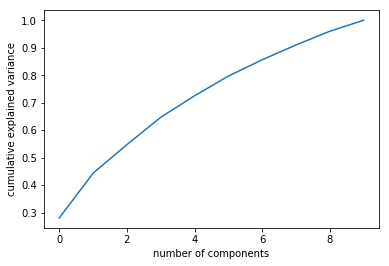

[ 0.28045581  0.16287538  0.10401848  0.09944951  0.07830754  0.07168217
  0.05922674  0.05407745  0.04990458  0.04000234]


In [18]:
X = heterogeneous_norm.iloc[:,:10]
pca = sklearnPCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

print(pca.explained_variance_ratio_)

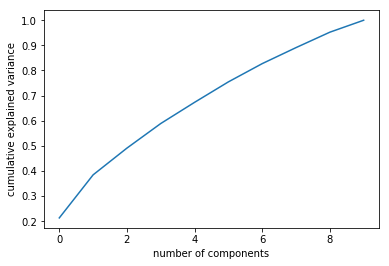

[ 0.21297111  0.17143826  0.10649641  0.09789868  0.08435425  0.0814477
  0.07264434  0.0637868   0.0613934   0.04756905]


In [19]:
X = homogeneous_norm.iloc[:,:10]
pca = sklearnPCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

print(pca.explained_variance_ratio_)

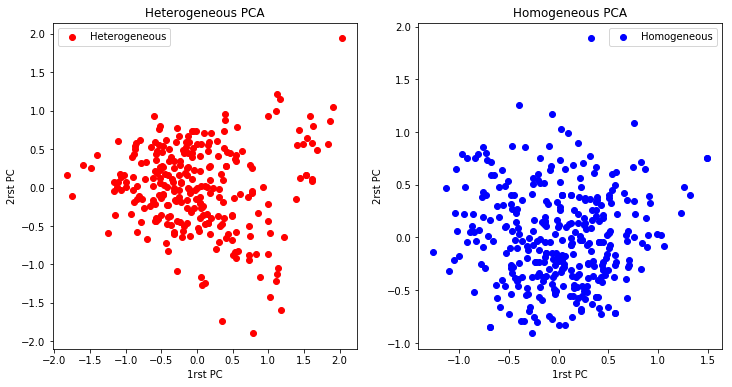

In [20]:
## Principal components for heterogeneous games, with and without ending rounds. 

n_clust = 3
X = heterogeneous_norm.iloc[:,:10]
k_means = KMeans(n_clusters=n_clust, random_state=0, n_init = 30).fit(X)
clustcoef_het = k_means.labels_
y_het = clustcoef_het
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed_het = pd.DataFrame(pca.fit_transform(X),index = X.index)

n_clust = 2
Y = homogeneous_norm.iloc[:,:10]
k_means = KMeans(n_clusters=n_clust, random_state=0).fit(Y)
clustcoef_hom = k_means.labels_
y_hom = clustcoef_hom
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed_hom = pd.DataFrame(pca.fit_transform(Y),index = Y.index)


#First Figure:
plt.figure(figsize=(12,6))
plt.subplot(121, title='Heterogeneous PCA')
plt.scatter(transformed_het[0], transformed_het[1], label='Heterogeneous', c='red')
plt.xlabel('1rst PC')
plt.ylabel('2rst PC')
plt.legend()

#Second Figure:
plt.subplot(122, title='Homogeneous PCA')
plt.scatter(transformed_hom[0], transformed_hom[1], label='Homogeneous', c='blue')
plt.xlabel('1rst PC')
plt.ylabel('2rst PC')
plt.legend()
plt.show()

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


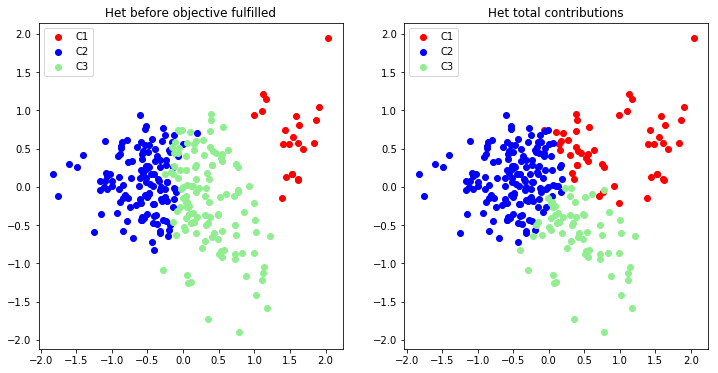

In [21]:

### PCA: 
n_clusters = 3
##Clustering individuals with all contributions:
X = heterogeneous_norm.iloc[:,:10]
##Standarize
#X = StandardScaler().fit_transform(X)
k_means = KMeans(n_clusters=n_clusters, random_state=0, n_init = 30).fit(X)
clustcoef_het = k_means.labels_
y_het = clustcoef_het
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)

## Redefine according results
#replace = {2: 0, 0: 1, 1: 2}
#def mp(entry,mapper_dict):
#    return mapper_dict.get(entry, entry)
#mp = np.vectorize(mp)
#
#y_het = np.array(mp(y_het,replace))

##Clustering individuals without ending round contributions:
X_ = pd.concat([table_het[table_het.experiment=='hetdau'].sort_index(),
                table_het[table_het.experiment=='street'].sort_index()])
##Standarize
#X_ = StandardScaler().fit_transform(X_)
labels, centroids, X_hat = kmeans_missing(X_.iloc[:,:10],n_clusters, max_iter=10)
y_0_het = labels


#Plots
plt.figure(figsize=(12,6))
plt.subplot(122, title='Het total contributions')
plt.scatter(transformed[y_het==0][0], transformed[y_het==0][1], label='C1', c='red')
plt.scatter(transformed[y_het==1][0], transformed[y_het==1][1], label='C2', c='blue')
plt.scatter(transformed[y_het==2][0], transformed[y_het==2][1], label='C3', c='lightgreen')
plt.legend()

plt.subplot(121, title='Het before objective fulfilled')
plt.scatter(transformed[y_0_het==0][0], transformed[y_0_het==0][1], label='C1', c='red')
plt.scatter(transformed[y_0_het==1][0], transformed[y_0_het==1][1], label='C2', c='blue')
plt.scatter(transformed[y_0_het==2][0], transformed[y_0_het==2][1], label='C3', c='lightgreen')
plt.legend()

plt.show()

### Heterogeneous Hierarchical Clustering

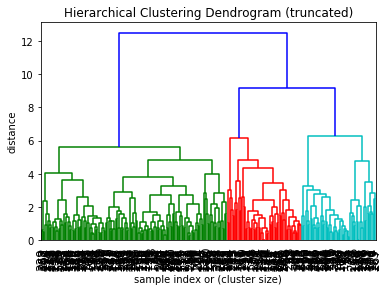

In [172]:
X = heterogeneous_norm.iloc[:,:10]
Z = ward(X)

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,

    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [173]:
from scipy.cluster.hierarchy import fcluster
max_d = 7
clusters = fcluster(Z, max_d, criterion='distance')
y = clusters

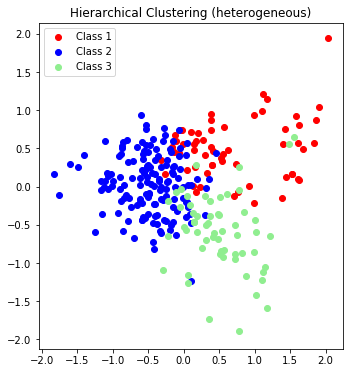

In [174]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X))

plt.figure(figsize=(12,6))
plt.subplot(121, title='Hierarchical Clustering (heterogeneous)')
plt.scatter(transformed[y==3][0], transformed[y==3][1], label='Class 1', c='red')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Class 2', c='blue')
plt.scatter(transformed[y==2][0], transformed[y==2][1], label='Class 3', c='lightgreen')
plt.legend()
plt.show()

### Heterogeneous Agglomerative Clustering

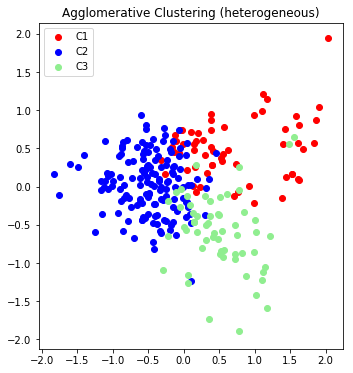

In [175]:
from sklearn.cluster import AgglomerativeClustering
X = heterogeneous_norm.iloc[:,:10]
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

plt.figure(figsize=(12,6))
plt.subplot(122, title='Agglomerative Clustering (heterogeneous)')
plt.scatter(transformed[assignment==0][0], transformed[assignment==0][1], label='C1', c='red')
plt.scatter(transformed[assignment==1][0], transformed[assignment==1][1], label='C2', c='blue')
plt.scatter(transformed[assignment==2][0], transformed[assignment==2][1], label='C3', c='lightgreen')
plt.legend()
#plt.xlabel("Feature 0")
#plt.ylabel("Feature 1")
plt.show()

### Heterogeneous DBSCAN

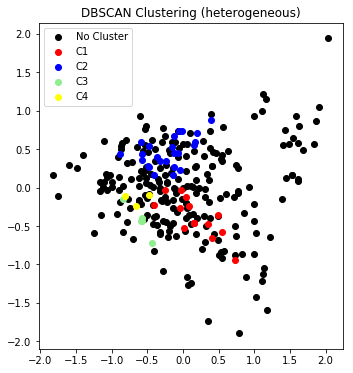

In [195]:
from sklearn.cluster import DBSCAN
X = heterogeneous_norm.iloc[:,:10]
dbscan = DBSCAN(min_samples=5)
assignment_dbscan = dbscan.fit_predict(X)


plt.figure(figsize=(12,6))
plt.subplot(122, title='DBSCAN Clustering (heterogeneous)')
plt.scatter(transformed[assignment_dbscan==-1][0], transformed[assignment_dbscan==-1][1], label='No Cluster', c='black')
plt.scatter(transformed[assignment_dbscan==0][0], transformed[assignment_dbscan==0][1], label='C1', c='red')
plt.scatter(transformed[assignment_dbscan==1][0], transformed[assignment_dbscan==1][1], label='C2', c='blue')
plt.scatter(transformed[assignment_dbscan==2][0], transformed[assignment_dbscan==2][1], label='C3', c='lightgreen')
plt.scatter(transformed[assignment_dbscan==3][0], transformed[assignment_dbscan==3][1], label='C4', c='yellow')
plt.legend()
#plt.xlabel("Feature 0")
#plt.ylabel("Feature 1")
plt.show()

In [72]:
categ_het['dbscan'] = assignment_dbscan

In [39]:
def counter(din_in):
    count_c = collections.Counter(din_in)
    c = []
    for key, value in count_c.items():
        #print(key)
        c.append(value)
    return(c)

In [117]:
## 'clust_coef' for all contribution;  'clust_coef2' for contributions withoud ending rounds
din_in_c1 = np.sort(categ_het[categ_het['dbscan']==-1].diners_inicials.values)
din_in_c2 = np.sort(categ_het[categ_het['dbscan']==0].diners_inicials.values)
din_in_c3 = np.sort(categ_het[categ_het['dbscan']==1].diners_inicials.values)

In [125]:
c1 = counter(din_in_c1)
c2 = counter(np.sort(din_in_c2))
var = 0
c2.insert(0,var)
c2.insert(0,var)
c3 = counter(din_in_c3)
c3.insert(0,var)


[0, 1, 1, 3, 5]

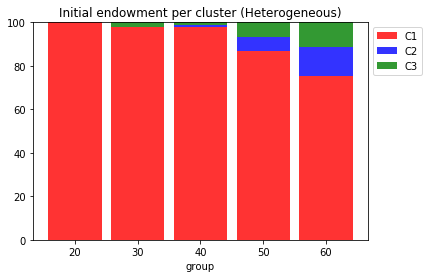

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# Data
r = [0,1,2,3,4]
raw_data = {'cluster1': c1, 'cluster2': c2,'cluster3': c3}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['cluster1'], df['cluster2'], df['cluster3'])]
cluster1 = [i / j * 100 for i,j in zip(df['cluster1'], totals)]
cluster2 = [i / j * 100 for i,j in zip(df['cluster2'], totals)]
cluster3 = [i / j * 100 for i,j in zip(df['cluster3'], totals)]
 
# plot
barWidth = 0.85
names = ('20','30','40','50','60')
# Create green Bars
plt.bar(r, cluster1, width=barWidth, label="C1", color='red', alpha = 0.8)
# Create orange Bars
plt.bar(r, cluster2, bottom=cluster1, width=barWidth, label="C2", color='blue', alpha = 0.8)
# Create blue Bars
plt.bar(r, cluster3, bottom=[i+j for i,j in zip(cluster1, cluster2)], width=barWidth, label="C3", color='green', alpha = 0.8)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1) 
plt.title('Initial endowment per cluster (Heterogeneous)')
# Show graphic
plt.show()


## Homogeneous K-Means:

### PCA representation:

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


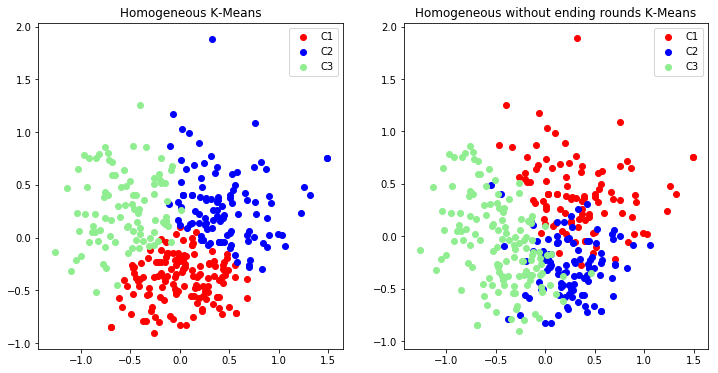

In [25]:
X = homogeneous_norm.iloc[:,:10]
k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
clustcoef_hom = k_means.labels_
y_hom = clustcoef_hom
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)

##Clustering individuals without ending round contributions:
X_ = pd.concat([table_hom[table_hom.experiment=='homdau'].sort_index(),
                table_hom[table_hom.experiment=='vil'].sort_index()])
labels, centroids, X_hat = kmeans_missing(X_.iloc[:,:10],n_clusters, max_iter=10)
y_0_hom = labels


plt.figure(figsize=(12,6))
plt.subplot(121, title='Homogeneous K-Means')
plt.scatter(transformed[y_hom==0][0], transformed[y_hom==0][1], label='C1', c='red')
plt.scatter(transformed[y_hom==1][0], transformed[y_hom==1][1], label='C2', c='blue')
plt.scatter(transformed[y_hom==2][0], transformed[y_hom==2][1], label='C3', c='lightgreen')
#for label, x, y in zip(transformed[y==0].index,transformed[y==0][ 0], transformed[y==0][1]):  
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.legend()
plt.subplot(122, title='Homogeneous without ending rounds K-Means')
plt.scatter(transformed[y_0_hom==0][0], transformed[y_0_hom==0][1], label='C1', c='red')
plt.scatter(transformed[y_0_hom==1][0], transformed[y_0_hom==1][1], label='C2', c='blue')
plt.scatter(transformed[y_0_hom==2][0], transformed[y_0_hom==2][1], label='C3', c='lightgreen')
#for label, x, y in zip(transformed_0[y_0==0].index,transformed_0[y_0==0][ 0], transformed_0[y_0==0][1]):  
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.legend()
plt.show()

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


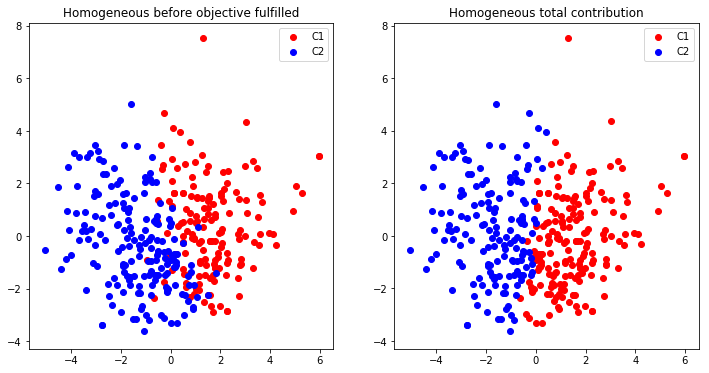

In [22]:
## 

n_clusters=2
X = homogeneous.iloc[:,:10]
k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
clustcoef_hom = k_means.labels_
y_hom2 = clustcoef_hom
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)

##Clustering individuals without ending round contributions:
X_ = pd.concat([table_hom[table_hom.experiment=='homdau'].sort_index(),
                table_hom[table_hom.experiment=='vil'].sort_index()])
labels, centroids, X_hat = kmeans_missing(X_.iloc[:,:10],n_clusters, max_iter=10)
y_0_hom2 = labels
y_0_hom2 = np.where(y_0_hom2 == 1, 0, 1)


plt.figure(figsize=(12,6))
plt.subplot(122, title='Homogeneous total contribution')
plt.scatter(transformed[y_hom2==0][0], transformed[y_hom2==0][1], label='C1', c='red')
plt.scatter(transformed[y_hom2==1][0], transformed[y_hom2==1][1], label='C2', c='blue')
#plt.scatter(transformed[y==2][0], transformed[y==2][1], label='Class 3', c='lightgreen')
#for label, x, y in zip(transformed[y==1].index,transformed[y==1][ 0], transformed[y==1][1]):  
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.legend()
plt.subplot(121, title='Homogeneous before objective fulfilled')
plt.scatter(transformed[y_0_hom2==0][0], transformed[y_0_hom2==0][1], label='C1', c='red')
plt.scatter(transformed[y_0_hom2==1][0], transformed[y_0_hom2==1][1], label='C2', c='blue')
#plt.scatter(transformed_0[y_0==2][0], transformed_0[y_0==2][1], label='Class 3', c='lightgreen')
#for label, x, y in zip(transformed_0[y_0==1].index,transformed_0[y_0==1][ 0], transformed_0[y_0==1][1]):  
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.legend()
plt.show()

### Homogeneous Hierarchical Clustering

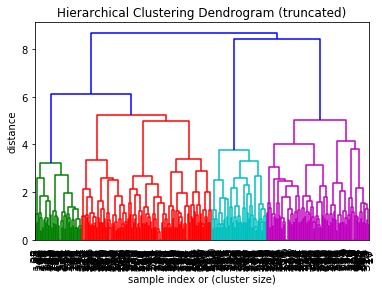

In [167]:
X = homogeneous_norm.iloc[:,:10]
Z = ward(X)

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,

    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [168]:
from scipy.cluster.hierarchy import fcluster
max_d = 7
clusters = fcluster(Z, max_d, criterion='distance')
y = clusters

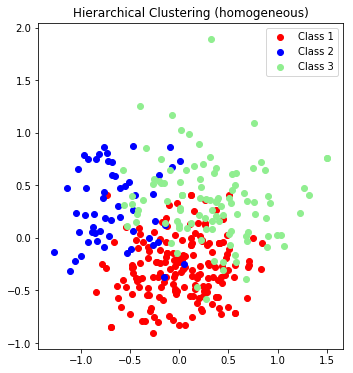

In [170]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X))

plt.figure(figsize=(12,6))
plt.subplot(121, title='Hierarchical Clustering (homogeneous)')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Class 1', c='red')
plt.scatter(transformed[y==2][0], transformed[y==2][1], label='Class 2', c='blue')
plt.scatter(transformed[y==3][0], transformed[y==3][1], label='Class 3', c='lightgreen')
plt.legend()
plt.show()

### Homogeneous Agglomerative Clustering

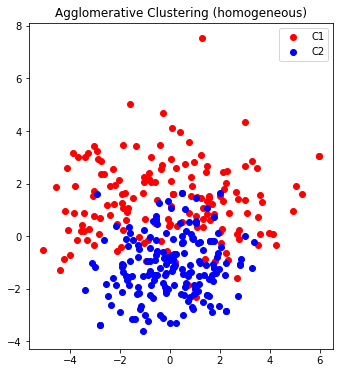

In [131]:
X = homogeneous_norm.iloc[:,:10]
agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X)

plt.figure(figsize=(12,6))
plt.subplot(122, title='Agglomerative Clustering (homogeneous)')
plt.scatter(transformed[assignment==0][0], transformed[assignment==0][1], label='C1', c='red')
plt.scatter(transformed[assignment==1][0], transformed[assignment==1][1], label='C2', c='blue')
#plt.scatter(transformed[assignment==2][0], transformed[assignment==2][1], label='C3', c='lightgreen')
plt.legend()
#plt.xlabel("Feature 0")
#plt.ylabel("Feature 1")
plt.show()

### Homogeneous DBSCAN

In [202]:
from sklearn.cluster import DBSCAN
X = homogeneous_norm.iloc[:,:10]
dbscan = DBSCAN(min_samples=4)
assignment_dbscan = dbscan.fit_predict(X)

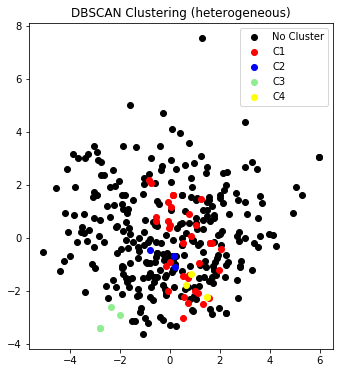

In [203]:
plt.figure(figsize=(12,6))
plt.subplot(122, title='DBSCAN Clustering (heterogeneous)')
plt.scatter(transformed[assignment_dbscan==-1][0], transformed[assignment_dbscan==-1][1], label='No Cluster', c='black')
plt.scatter(transformed[assignment_dbscan==0][0], transformed[assignment_dbscan==0][1], label='C1', c='red')
plt.scatter(transformed[assignment_dbscan==1][0], transformed[assignment_dbscan==1][1], label='C2', c='blue')
plt.scatter(transformed[assignment_dbscan==2][0], transformed[assignment_dbscan==2][1], label='C3', c='lightgreen')
plt.scatter(transformed[assignment_dbscan==3][0], transformed[assignment_dbscan==3][1], label='C4', c='yellow')
plt.legend()
#plt.xlabel("Feature 0")
#plt.ylabel("Feature 1")
plt.show()

In [ ]:
categ_hom['dbscan'] = assignment_dbscan

### Identification of clusters: 

First: find the initial endowment of each cluster (categ_ variable) and plot the histogram.
Second: Variables total contribution / endowment, mean contribution distributions.
Third: Evolution in the mean contribution of each cluster. 

In [23]:
def label_saving (row,category):
    if row[category] < 0.33 :
        return 0
    if row[category] >= 0.33 and row[category] <= 0.66 :
        return 1
    else:
        return 2

In [24]:
def label_saving_4 (row,category):
    if row[category] < 0.250 :
        return 0
    if row[category] >= 0.250 and row[category] < 0.500:
        return 1
    if row[category] >= 0.500 and row[category] < 0.750 :
        return 2
    else:
        return 3

In [25]:
def categories (contr_ds,user_ds):
    category_ds = user_ds.loc[:,["user_id","diners_inicials",'partida_id']]
    category_ds.set_index('user_id', inplace=True)
    category_ds['contr_total']=contr_ds.sum(axis=1)
    category_ds['mean_contr']=contr_ds.mean(axis=1)
    category_ds['contr/budget']= (category_ds.contr_total)/ category_ds.diners_inicials
    category_ds['category']=category_ds.apply (lambda row: label_saving (row,'contr/budget'),axis=1)
    category_ds['category4']=category_ds.apply (lambda row: label_saving_4 (row,'contr/budget'),axis=1) 
    return category_ds

In [26]:
def categories_norm (contr_ds,user_ds):
    category_ds = user_ds.loc[:,["user_id","diners_inicials",'partida_id']]
    category_ds.set_index('user_id', inplace=True)
    #category_ds= category_ds.reindex(category_ds.loc[:,'user_id'])
    category_ds['contr_total_norm']=contr_ds.sum(axis=1)
    return category_ds

In [27]:
category_ineq_dau = categories(ineq_contr_dau, ineq_user_dau)
category_eq_dau = categories(eq_contr_dau, eq_user_dau)
category_street = categories(contr_street,user_street)
category_vil = categories(contr_vil, user_vil)

In [28]:
cat_ineq_dau = categories_norm(ineq_contr_dau_norm, ineq_user_dau)
cat_eq_dau = categories_norm(eq_contr_dau_norm, eq_user_dau)
cat_street = categories_norm(contr_street_norm,user_street)
cat_vil = categories_norm(contr_vil_norm, user_vil)

In [29]:
categ_het=pd.concat([category_ineq_dau,category_street])
categ_hom=pd.concat([category_eq_dau,category_vil])

In [30]:
categ_het['clust_coef']=y_het
#categ_het['experiment']=heterogeneous_norm.experiment
categ_hom['clust_coef']=y_hom2
#categ_hom['experiment']=homogeneous_norm.experiment
#
#categ_het.to_csv('dades/categ_het.csv' ,sep=',', index=True)
#categ_hom.to_csv('dades/categ_hom.csv' ,sep=',', index=True)

heterogeneous_norm['clust_coef']= y_het
heterogeneous['clust_coef']= y_het
homogeneous_norm['clust_coef']= y_hom2
homogeneous['clust_coef']= y_hom2

In [31]:
## Add new cluster identification after substract final rounds:

categ_het['clust_coef2']=y_0_het
categ_hom['clust_coef2']=y_0_hom2

### Cluster identification: Statistical information about clusters

In [34]:
## Contribution table of each cluster: 
# heterogeneous (three clusters)
X = heterogeneous_norm
clust1_het = X.iloc[y_het == 0]
clust2_het = X.iloc[y_het == 1]
clust3_het = X.iloc[y_het == 2]

# homogeneous (three clusters)
Y = homogeneous_norm
clust1_hom = Y.iloc[y_hom == 0]
clust2_hom = Y.iloc[y_hom == 1]
clust3_hom = Y.iloc[y_hom == 2]

# homogeneous (two clusters)

clust1_hom2 = Y.iloc[y_hom2 == 0]
clust2_hom2 = Y.iloc[y_hom2 == 1]


#### Heterogeneous games: 

In [38]:
#Normalized mean contribution per user:
mean_user_c1 = clust1_het.iloc[:,:10].mean(axis=1)
mean_user_c1.describe()

count    51.000000
mean      0.790425
std       0.171029
min       0.500000
25%       0.650000
50%       0.800000
75%       1.000000
max       1.000000
dtype: float64

In [39]:
mean_user_c2 = clust2_het.iloc[:,:10].mean(axis=1)
mean_user_c2.describe()

count    152.000000
mean       0.417555
std        0.120775
min        0.000000
25%        0.350000
50%        0.440000
75%        0.500000
max        0.666667
dtype: float64

In [40]:
mean_user_c3 = clust3_het.iloc[:,:10].mean(axis=1)
mean_user_c3.describe()

count    67.000000
mean      0.751020
std       0.135769
min       0.520000
25%       0.645000
50%       0.733333
75%       0.837500
max       1.000000
dtype: float64

#### Clusters without ending rounds

In [41]:
X.shape

(270, 12)

In [42]:
## Define cluster contributions table
X = heterogeneous_norm
clust1_het_b = X.iloc[y_0_het == 0]
clust2_het_b = X.iloc[y_0_het == 1]
clust3_het_b = X.iloc[y_0_het == 2]

Y = homogeneous_norm
clust1_hom2_b = Y.iloc[y_0_hom2 == 0]
clust2_hom2_b = Y.iloc[y_0_hom2 == 1]

In [43]:
#Normalized mean contribution per user:
mean_user_c1 = clust1_het_b.iloc[:,:10].mean(axis=1)
mean_user_c1.describe()

count    22.000000
mean      0.953788
std       0.078668
min       0.800000
25%       0.937500
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

In [44]:
mean_user_c2 = clust2_het_b.iloc[:,:10].mean(axis=1)
mean_user_c2.describe()

count    128.000000
mean       0.394336
std        0.115683
min        0.000000
25%        0.333333
50%        0.400000
75%        0.470000
max        0.600000
dtype: float64

In [192]:
mean_user_c3 = clust3_het_b.iloc[:,:10].mean(axis=1)
mean_user_c3.describe()

count    120.000000
mean       0.688667
std        0.141360
min        0.466667
25%        0.600000
50%        0.666667
75%        0.770000
max        1.000000
dtype: float64

In [43]:
X = homogeneous_norm
clust1 = X.iloc[y_0_hom == 0]
clust2 = X.iloc[y_0_hom == 1]
#clust3 = X.iloc[y_0_hom == 2]

### Cluster identification: Initial endowment of each cluster

In [35]:
#import collections, numpy
#
#def counter(din_in):
#    count_c = collections.Counter(din_in)
#    c = []
#    for key, value in count_c.items():
#        c.append(value)
#    return(c)

In [36]:
## 'clust_coef' for all contribution;  'clust_coef2' for contributions withoud ending rounds
din_in_c1 = np.sort(categ_het[categ_het['clust_coef']==0].diners_inicials.values)
din_in_c2 = np.sort(categ_het[categ_het['clust_coef']==1].diners_inicials.values)
din_in_c3 = np.sort(categ_het[categ_het['clust_coef']==2].diners_inicials.values)

In [37]:
din_in_c3

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 60, 60, 60, 60, 60], dtype=int64)

In [40]:
c1 = counter(din_in_c1)
c1.append(0)
#c1.append(0)
#c1.append(0)
c2 = counter(din_in_c2)
c3 = counter(din_in_c3)

In [41]:
c1

[20, 16, 13, 2, 0]

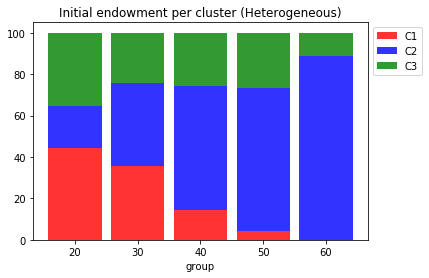

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# Data
r = [0,1,2,3,4]
raw_data = {'cluster1': c1, 'cluster2': c2,'cluster3': c3}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['cluster1'], df['cluster2'], df['cluster3'])]
cluster1 = [i / j * 100 for i,j in zip(df['cluster1'], totals)]
cluster2 = [i / j * 100 for i,j in zip(df['cluster2'], totals)]
cluster3 = [i / j * 100 for i,j in zip(df['cluster3'], totals)]
 
# plot
barWidth = 0.85
names = ('20','30','40','50','60')
# Create green Bars
plt.bar(r, cluster1, width=barWidth, label="C1", color='red', alpha = 0.8)
# Create orange Bars
plt.bar(r, cluster2, bottom=cluster1, width=barWidth, label="C2", color='blue', alpha = 0.8)
# Create blue Bars
plt.bar(r, cluster3, bottom=[i+j for i,j in zip(cluster1, cluster2)], width=barWidth, label="C3", color='green', alpha = 0.8)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1) 
plt.title('Initial endowment per cluster (Heterogeneous)')
# Show graphic
plt.show()



In [112]:
categ_het['experiment']=heterogeneous_norm['experiment']
## Separate Heterogeneous DAU from STREET:

categ_dau = categ_het[categ_het['experiment'] == 'het_dau']
categ_street = categ_het[categ_het['experiment'] == 'street']

#Heterogeneous DAU: 
din_in_c1_d = np.sort(categ_dau[categ_dau['clust_coef2']==0].diners_inicials.values)
din_in_c2_d = np.sort(categ_dau[categ_dau['clust_coef2']==1].diners_inicials.values)
din_in_c3_d = np.sort(categ_dau[categ_dau['clust_coef2']==2].diners_inicials.values)

#STREET:
din_in_c1_s = np.sort(categ_street[categ_street['clust_coef2']==0].diners_inicials.values)
din_in_c2_s = np.sort(categ_street[categ_street['clust_coef2']==1].diners_inicials.values)
din_in_c3_s = np.sort(categ_street[categ_street['clust_coef2']==2].diners_inicials.values)

## Function count the number of times a certain value is repeated. 
# Heterogeneous DAU:
c1_d = counter(din_in_c1_d)
c1_d.append(0)
c1_d.append(0)
c1_d.append(0)
c2_d = counter(din_in_c2_d)
c3_d = counter(din_in_c3_d)

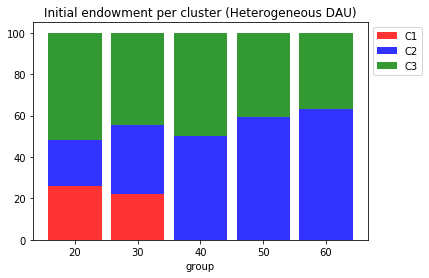

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# Data
r = [0,1,2,3,4]
raw_data = {'cluster1': c1_d, 'cluster2': c2_d,'cluster3': c3_d}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['cluster1'], df['cluster2'], df['cluster3'])]
cluster1 = [i / j * 100 for i,j in zip(df['cluster1'], totals)]
cluster2 = [i / j * 100 for i,j in zip(df['cluster2'], totals)]
cluster3 = [i / j * 100 for i,j in zip(df['cluster3'], totals)]
 
# plot
barWidth = 0.85
names = ('20','30','40','50','60')
# Create green Bars
plt.bar(r, cluster1, width=barWidth, label="C1", color='red', alpha = 0.8)
# Create orange Bars
plt.bar(r, cluster2, bottom=cluster1, width=barWidth, label="C2", color='blue', alpha = 0.8)
# Create blue Bars
plt.bar(r, cluster3, bottom=[i+j for i,j in zip(cluster1, cluster2)], 
        width=barWidth, label="C3", color='green', alpha = 0.8)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1) 
plt.title('Initial endowment per cluster (Heterogeneous DAU)')
# Show graphic
plt.show()


In [114]:
## Function count the number of times a certain value is repeated. 
# STREET:
c1_s = counter(din_in_c1_s)
c1_s.append(0)
c1_s.append(0)
c1_s.append(0)
c2_s = counter(din_in_c2_s)
c3_s = counter(din_in_c3_s)

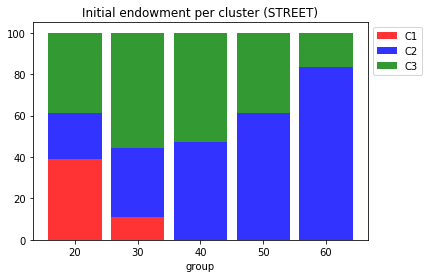

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# Data
r = [0,1,2,3,4]
raw_data = {'cluster1': c1_s, 'cluster2': c2_s,'cluster3': c3_s}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['cluster1'], df['cluster2'], df['cluster3'])]
cluster1 = [i / j * 100 for i,j in zip(df['cluster1'], totals)]
cluster2 = [i / j * 100 for i,j in zip(df['cluster2'], totals)]
cluster3 = [i / j * 100 for i,j in zip(df['cluster3'], totals)]
 
# plot
barWidth = 0.85
names = ('20','30','40','50','60')
# Create green Bars
plt.bar(r, cluster1, width=barWidth, label="C1", color='red', alpha = 0.8)
# Create orange Bars
plt.bar(r, cluster2, bottom=cluster1, width=barWidth, label="C2", color='blue', alpha = 0.8)
# Create blue Bars
plt.bar(r, cluster3, bottom=[i+j for i,j in zip(cluster1, cluster2)], width=barWidth, label="C3", color='green', alpha = 0.8)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1) 
plt.title('Initial endowment per cluster (STREET)')
# Show graphic
plt.show()


### Initial endowment homogeneous case: 

In [40]:
categ_hom['experiment']=homogeneous_norm['experiment']
## Separate Heterogeneous DAU from STREET:

In [41]:
categ_dau = categ_hom[categ_hom['experiment'] == 'hom_dau']
categ_vil = categ_hom[categ_hom['experiment'] == 'vil']

#Homogeneous DAU: 
din_in_c1_d = categ_dau[categ_dau['clust_coef']==0].diners_inicials.values
din_in_c2_d = categ_dau[categ_dau['clust_coef']==1].diners_inicials.values

c1_d = counter(din_in_c1_d)
c2_d = counter(din_in_c2_d)

In [42]:
#VIL:
din_in_c1_v = categ_vil[categ_vil['clust_coef']==0].diners_inicials.values
din_in_c2_v = categ_vil[categ_vil['clust_coef']==1].diners_inicials.values

c1_v = counter(din_in_c1_v)
c2_v = counter(din_in_c2_v)




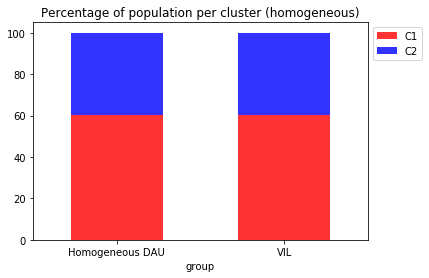

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

# Data
r = [0,1]
raw_data = {'cluster1': c1_d, 'cluster2': c2_d}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['cluster1'], df['cluster2'])]
cluster1 = [i / j * 100 for i,j in zip(df['cluster1'], totals)]
cluster2 = [i / j * 100 for i,j in zip(df['cluster2'], totals)]
#cluster3 = [i / j * 100 for i,j in zip(df['cluster3'], totals)]
 
# plot
barWidth = 0.55
names = ('Homogeneous DAU', 'VIL')
# Create green Bars
plt.bar(r, cluster1, width=barWidth, label="C1", color='red', alpha = 0.8)
# Create orange Bars
plt.bar(r, cluster2, bottom=cluster1, width=barWidth, label="C2", color='blue', alpha = 0.8)
# Create blue Bars
#plt.bar(r, cluster3, bottom=[i+j for i,j in zip(cluster1, cluster2)], 
#        width=barWidth, label="C3", color='green', alpha = 0.8)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1) 
plt.title('Percentage of population per cluster (homogeneous)')
plt.xlim(-0.5,1.5)

# Show graphic
plt.show()


### Cluster identification: tcontr/endowment, mean contribution

#### Heterogeneous games:

In [33]:
X = heterogeneous_norm
clust1_1 = X.iloc[y_het == 0]
clust2_1 = X.iloc[y_het == 1]
clust3_1 = X.iloc[y_het == 2]

##Clusters without ending rounds
#clust1 = X.iloc[y_0_het == 0]
#clust2 = X.iloc[y_0_het == 1]
#clust3 = X.iloc[y_0_het == 2]


def cluster_analysis_het(contr_treat,y_treat,exp1,exp2):
    X = contr_treat
    clust1 = X.iloc[y_treat == 0]
    clust2 = X.iloc[y_treat == 1]
    clust3 = X.iloc[y_treat == 2]
    
    contr_1 = ineq_contr_dau[ineq_contr_dau.index.isin(clust1[clust1.experiment==exp1].index)]
    contr_2 = contr_street[contr_street.index.isin(clust1[clust1.experiment==exp2].index)]
    contr_het_1 = pd.concat([contr_1,contr_2])

    user_1 = ineq_user_dau[ineq_user_dau.user_id.isin(clust1[clust1.experiment==exp1].index)]
    user_2 = user_street[user_street.user_id.isin(clust1[clust1.experiment==exp2].index)]
    user_het_1 = pd.concat([user_1,user_2])

    c1_het = categories(contr_het_1,user_het_1)

    contr_1 = ineq_contr_dau[ineq_contr_dau.index.isin(clust2[clust2.experiment==exp1].index)]
    contr_2 = contr_street[contr_street.index.isin(clust2[clust2.experiment==exp2].index)]
    contr_het_2 = pd.concat([contr_1,contr_2])

    user_1 = ineq_user_dau[ineq_user_dau.user_id.isin(clust2[clust2.experiment==exp1].index)]
    user_2 = user_street[user_street.user_id.isin(clust2[clust2.experiment==exp2].index)]
    user_het_2 = pd.concat([user_1,user_2])

    c2_het = categories(contr_het_2,user_het_2)

    contr_1 = ineq_contr_dau[ineq_contr_dau.index.isin(clust3[clust3.experiment==exp1].index)]
    contr_2 = contr_street[contr_street.index.isin(clust3[clust3.experiment==exp2].index)]
    contr_het_3 = pd.concat([contr_1,contr_2])

    user_1 = ineq_user_dau[ineq_user_dau.user_id.isin(clust3[clust3.experiment==exp1].index)]
    user_2 = user_street[user_street.user_id.isin(clust3[clust3.experiment==exp2].index)]
    user_het_3 = pd.concat([user_1,user_2])

    c3_het = categories(contr_het_3,user_het_3)
    
    return([c1_het,c2_het,c3_het])

In [34]:
clust_before = cluster_analysis_het(heterogeneous_norm, y_0_het, 'het_dau', 'street')
clust_tot = cluster_analysis_het(heterogeneous_norm, y_het, 'het_dau', 'street')

In [35]:
from scipy.stats import chisquare,ttest_ind
## T-test for the different treatment proportional contribution distribution before and after the objective is fulfilled.
print("T-test C1 and C2:",ttest_ind(clust_tot[0]['contr/budget'],clust_tot[1]['contr/budget']))
print("T-test C2 and C3:",ttest_ind(clust_tot[1]['contr/budget'],clust_tot[2]['contr/budget']))
print("T-test C1 and C3:",ttest_ind(clust_tot[0]['contr/budget'],clust_tot[2]['contr/budget']))

T-test C1 and C2: Ttest_indResult(statistic=17.020140855837536, pvalue=8.0960831454678733e-41)
T-test C2 and C3: Ttest_indResult(statistic=-18.082720142568206, pvalue=3.4447131865827671e-45)
T-test C1 and C3: Ttest_indResult(statistic=1.3338769742721008, pvalue=0.18485719232133968)


In [36]:
from scipy.stats import chisquare,ttest_ind
## T-test for the different treatment proportional contribution distribution before and after the objective is fulfilled.
print("T-test C1 and C2:",ttest_ind(clust_before[0]['contr/budget'],clust_before[1]['contr/budget']))
print("T-test C2 and C3:",ttest_ind(clust_before[1]['contr/budget'],clust_before[2]['contr/budget']))
print("T-test C1 and C3:",ttest_ind(clust_before[0]['contr/budget'],clust_before[2]['contr/budget']))

T-test C1 and C2: Ttest_indResult(statistic=21.560305642980346, pvalue=1.6236982694023066e-47)
T-test C2 and C3: Ttest_indResult(statistic=-17.95023744651801, pvalue=1.2829784762865956e-46)
T-test C1 and C3: Ttest_indResult(statistic=8.3941178060232851, pvalue=4.6424634994072459e-14)


In [48]:
from scipy.stats import chisquare,ttest_ind
## T-test for the different treatment proportional contribution distribution before and after the objective is fulfilled.
ttest_ind(clust_before[2]['contr/budget'],clust_tot[2]['contr/budget'])

Ttest_indResult(statistic=-2.933129884485199, pvalue=0.0037799929336569419)

In [49]:
ttest_ind(clust_before[1]['contr/budget'],clust_tot[1]['contr/budget'])

Ttest_indResult(statistic=-1.6264382715918591, pvalue=0.1049894067466783)

In [50]:
ttest_ind(clust_before[0]['contr/budget'],clust_tot[0]['contr/budget'])

Ttest_indResult(statistic=4.2514119533667891, pvalue=6.3628570079372375e-05)

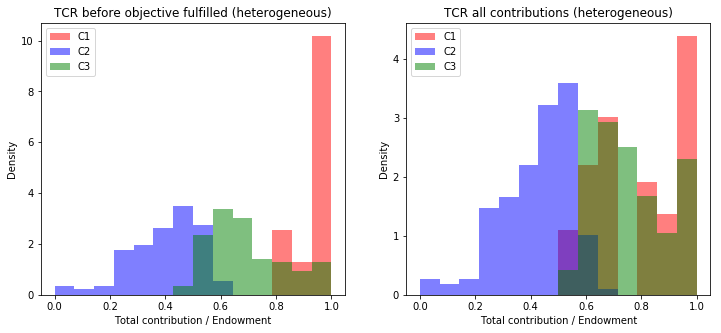

In [45]:
bins = np.linspace(0, 1, 15)

#Plots
plt.figure(figsize=(12,5))
plt.subplot(121, title='TCR before objective fulfilled (heterogeneous)')

plt.hist(clust_before[0]['contr/budget'], bins, alpha=0.5,density = True, label='C1', color = 'red')
plt.hist(clust_before[1]['contr/budget'], bins, alpha=0.5,density = True, label='C2', color='blue')
plt.hist(clust_before[2]['contr/budget'], bins, alpha=0.5,density = True, label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')


plt.subplot(122, title='TCR all contributions (heterogeneous)')
plt.hist(clust_tot[0]['contr/budget'], bins, alpha=0.5,density = True, label='C1', color = 'red')
plt.hist(clust_tot[1]['contr/budget'], bins, alpha=0.5,density = True, label='C2', color='blue')
plt.hist(clust_tot[2]['contr/budget'], bins, alpha=0.5,density = True, label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')
plt.show()



In [45]:
print('Mean prop. contr. C1 (heterogeneous):',clust_tot[0]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (heterogeneous):',stats.sem(clust_tot[0]['contr/budget']))
print('SD prop. contr. C1 (heterogeneous):',clust_tot[0]['contr/budget'].std())
print('\n')

print('Mean prop. contr. C2 (heterogeneous):',clust_tot[1]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (heterogeneous):',stats.sem(clust_tot[1]['contr/budget']))
print('SD prop. contr. C2 (heterogeneous):',clust_tot[1]['contr/budget'].std())
print('\n')

print('Mean prop. contr. C3 (heterogeneous):',clust_tot[2]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (heterogeneous):',stats.sem(clust_tot[2]['contr/budget']))
print('SD prop. contr. C3 (heterogeneous):',clust_tot[2]['contr/budget'].std())
print('\n')

Mean prop. contr. C1 (heterogeneous): 0.7884640522875817
SE Mean prop. contr. C1 (heterogeneous): 0.0236844195193
SD prop. contr. C1 (heterogeneous): 0.16914058686891698


Mean prop. contr. C2 (heterogeneous): 0.41788377192982445
SE Mean prop. contr. C1 (heterogeneous): 0.00980891424227
SD prop. contr. C2 (heterogeneous): 0.12093241661797374


Mean prop. contr. C3 (heterogeneous): 0.7510199004975125
SE Mean prop. contr. C1 (heterogeneous): 0.0165868341015
SD prop. contr. C3 (heterogeneous): 0.1357690884893006




In [57]:
print('Mean prop. contr. C1 (heterogeneous):',clust_before[0]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (heterogeneous):',stats.sem(clust_before[0]['contr/budget']))
print('SD prop. contr. C1 (heterogeneous):',clust_before[0]['contr/budget'].std())
print('\n')

print('Mean prop. contr. C2 (heterogeneous):',clust_before[1]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (heterogeneous):',stats.sem(clust_before[1]['contr/budget']))
print('SD prop. contr. C2 (heterogeneous):',clust_before[1]['contr/budget'].std())
print('\n')

print('Mean prop. contr. C3 (heterogeneous):',clust_before[2]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (heterogeneous):',stats.sem(clust_before[2]['contr/budget']))
print('SD prop. contr. C3 (heterogeneous):',clust_before[2]['contr/budget'].std())
print('\n')

Mean prop. contr. C1 (heterogeneous): 0.9492424242424243
SE Mean prop. contr. C1 (heterogeneous): 0.0167916408494
SD prop. contr. C1 (heterogeneous): 0.07875977687311239


Mean prop. contr. C2 (heterogeneous): 0.3947265624999998
SE Mean prop. contr. C1 (heterogeneous): 0.0102492080557
SD prop. contr. C2 (heterogeneous): 0.11595655228807357


Mean prop. contr. C3 (heterogeneous): 0.6886666666666665
SE Mean prop. contr. C1 (heterogeneous): 0.0129043320824
SD prop. contr. C3 (heterogeneous): 0.14135987542115683




In [ ]:
from scipy.stats import chisquare,ttest_ind
## T-test for the different cluster proportional contribution distribution (not different)
ttest_ind(hom_before[0]['contr/budget'],hom_after[0]['contr/budget'])

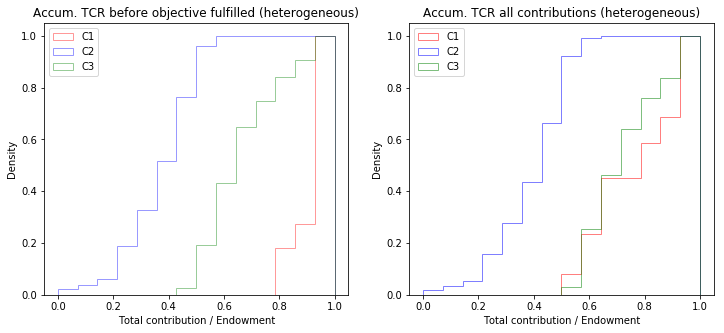

In [47]:
#Plots
plt.figure(figsize=(12,5))
plt.subplot(121, title='Accum. TCR before objective fulfilled (heterogeneous)')

plt.hist(clust_before[0]['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step',rwidth =50, label='C1', color = 'red')
plt.hist(clust_before[1]['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C2', color='blue')
plt.hist(clust_before[2]['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C3', color= 'green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')


plt.subplot(122, title='Accum. TCR all contributions (heterogeneous)')
plt.hist(clust_tot[0]['contr/budget'], bins, alpha=0.5,density = True,cumulative=True,histtype='step', label='C1', color = 'red')
plt.hist(clust_tot[1]['contr/budget'], bins, alpha=0.5,density = True,cumulative=True,histtype='step', label='C2', color='blue')
plt.hist(clust_tot[2]['contr/budget'], bins, alpha=0.5,density = True,cumulative=True,histtype='step', label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')
plt.show()

In [63]:
#bins = np.linspace(0, 1, 20)
#
#plt.hist(c1_het['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step',rwidth =50, label='C1', color = 'red')
#plt.hist(c2_het['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C2', color='blue')
#plt.hist(c3_het['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C3', color= 'green')
##plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
#plt.xlabel("Total contribution / Endowment")
#plt.ylabel("Accum. Density")
#plt.legend(loc='upper left')
#plt.title('Total contribution ratio (heterogeneous) cdf')
#plt.show()

In [ ]:
## Hist mean contribution per cluster
#bins = np.linspace(0,4, 20)
#
#plt.hist(c1_het['mean_contr'], bins, alpha=0.4,density = True, label='C1', color = 'red')
#plt.hist(c2_het['mean_contr'], bins, alpha=0.4,density = True, label='C2', color='blue')
#plt.hist(c3_het['mean_contr'], bins, alpha=0.4,density = True, label='C3', color='green')
##plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
#plt.xlabel("Mean Contribution")
#plt.ylabel("Density")
#plt.legend(loc='upper right')
#plt.title('Mean contribution (heterogeneous) histogram')
#plt.show()

In [52]:
### Cdf mean contribution per cluster
#bins = np.linspace(0, 4, 20)
#
#plt.hist(c1_het['mean_contr'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C1', color ='red')
#plt.hist(c2_het['mean_contr'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C2', color='blue')
#plt.hist(c3_het['mean_contr'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C3', color='green')
##plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
#plt.xlabel("Mean Contribution")
#plt.ylabel("Accum. Density")
#plt.legend(loc='upper left')
#plt.title('Mean contribution (heterogeneous) cdf')
#plt.show()

## Homogeneous cluster 

In [37]:

def cluster_analysis_hom(contr_treat, y_treat):
    X = contr_treat
    clust1 = X.iloc[y_treat == 0]
    clust2 = X.iloc[y_treat == 1]
#    clust3 = X.iloc[y_treat == 2]
    
    contr_1 = ineq_contr_dau[ineq_contr_dau.index.isin(clust1[clust1.experiment=='hom_dau'].index)]
    contr_2 = contr_street[contr_street.index.isin(clust1[clust1.experiment=='vil'].index)]
    contr_hom_1 = pd.concat([contr_1,contr_2])
    
    user_1 = ineq_user_dau[ineq_user_dau.user_id.isin(clust1[clust1.experiment=='hom_dau'].index)]
    user_2 = user_street[user_street.user_id.isin(clust1[clust1.experiment=='vil'].index)]
    user_hom_1 = pd.concat([user_1,user_2])
    
    c1_hom = categories(contr_hom_1,user_hom_1)
    
    contr_1 = ineq_contr_dau[ineq_contr_dau.index.isin(clust2[clust2.experiment=='hom_dau'].index)]
    contr_2 = contr_street[contr_street.index.isin(clust2[clust2.experiment=='vil'].index)]
    contr_hom_2 = pd.concat([contr_1,contr_2])
    
    user_1 = ineq_user_dau[ineq_user_dau.user_id.isin(clust2[clust2.experiment=='hom_dau'].index)]
    user_2 = user_street[user_street.user_id.isin(clust2[clust2.experiment=='vil'].index)]
    user_hom_2 = pd.concat([user_1,user_2])
    
    c2_hom = categories(contr_hom_2,user_hom_2)
    
#    contr_1 = ineq_contr_dau[ineq_contr_dau.index.isin(clust3[clust3.experiment=='hom_dau'].index)]
#    contr_2 = contr_street[contr_street.index.isin(clust3[clust3.experiment=='vil'].index)]
#    contr_hom_3 = pd.concat([contr_1,contr_2])
#    
#    user_1 = ineq_user_dau[ineq_user_dau.user_id.isin(clust3[clust3.experiment=='hom_dau'].index)]
#    user_2 = user_street[user_street.user_id.isin(clust3[clust3.experiment=='vil'].index)]
#    user_hom_3 = pd.concat([user_1,user_2])
#    
#    c3_hom = categories(contr_hom_3,user_hom_3)
    return([c1_hom,c2_hom])

In [41]:
hom_before = cluster_analysis_hom(homogeneous_norm, y_hom2)
hom_tot = cluster_analysis_hom(homogeneous_norm, y_0_hom2)

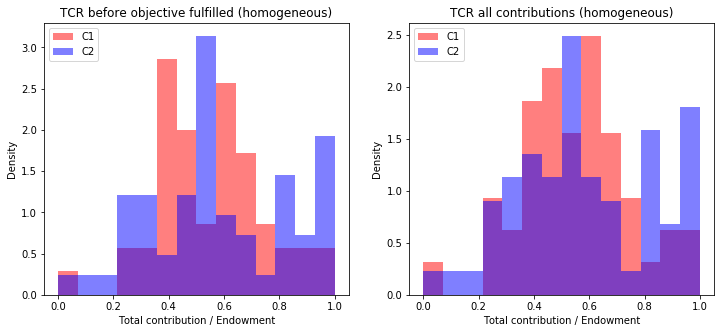

In [44]:
bins = np.linspace(0, 1, 15)

#Plots
plt.figure(figsize=(12,5))
plt.subplot(121, title='TCR before objective fulfilled (homogeneous)')

plt.hist(hom_before[0]['contr/budget'], bins, alpha=0.5,density = True, label='C1', color = 'red')
plt.hist(hom_before[1]['contr/budget'], bins, alpha=0.5,density = True, label='C2', color='blue')
#plt.hist(hom_before[2]['contr/budget'], bins, alpha=0.5,density = True, label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')


plt.subplot(122, title='TCR all contributions (homogeneous)')
plt.hist(hom_tot[0]['contr/budget'], bins, alpha=0.5,density = True, label='C1', color = 'red')
plt.hist(hom_tot[1]['contr/budget'], bins, alpha=0.5,density = True, label='C2', color='blue')
#plt.hist(hom_tot[2]['contr/budget'], bins, alpha=0.5,density = True, label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')
plt.show()



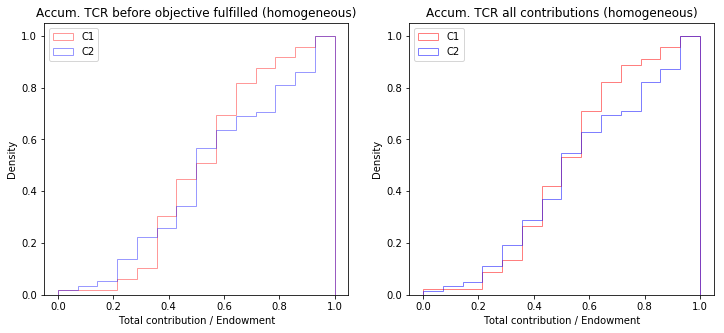

In [51]:
#Plots
plt.figure(figsize=(12,5))
plt.subplot(121, title='Accum. TCR before objective fulfilled (homogeneous)')

plt.hist(hom_before[0]['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step',rwidth =50, label='C1', color = 'red')
plt.hist(hom_before[1]['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C2', color='blue')
#plt.hist(hom_before[2]['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C3', color= 'green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')


plt.subplot(122, title='Accum. TCR all contributions (homogeneous)')
plt.hist(hom_tot[0]['contr/budget'], bins, alpha=0.5,density = True,cumulative=True,histtype='step', label='C1', color = 'red')
plt.hist(hom_tot[1]['contr/budget'], bins, alpha=0.5,density = True,cumulative=True,histtype='step', label='C2', color='blue')
#plt.hist(hom_tot[2]['contr/budget'], bins, alpha=0.5,density = True,cumulative=True,histtype='step', label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
#plt.title('Proportional contribution histogram (heterogeneous)')
plt.show()

In [78]:
print('Mean prop. contr. C1 before:',hom_before[0]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (hom):',stats.sem(hom_before[0]['contr/budget']))
print('SD prop. contr. C1 before:',hom_before[0]['contr/budget'].std())

print('Mean prop. contr. C1 after:',hom_after[0]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (hom):',stats.sem(hom_after[0]['contr/budget']))
print('SD prop. contr. C1 after:',hom_after[0]['contr/budget'].std())

print('\n')

print('Mean prop. contr. C2 before:',hom_before[1]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (hom):',stats.sem(hom_before[0]['contr/budget']))
print('SD prop. contr. C2 before:',hom_before[1]['contr/budget'].std())

print('Mean prop. contr. C2 after:',hom_after[1]['contr/budget'].mean())
print('SE Mean prop. contr. C1 (hom):',stats.sem(hom_after[1]['contr/budget']))
print('SD prop. contr. C2 after:',hom_after[1]['contr/budget'].std())




Mean prop. contr. C1 before: 0.5474149659863945
SE Mean prop. contr. C1 (hom): 0.0279989379499
SD prop. contr. C1 before: 0.19599256564949472
Mean prop. contr. C1 after: 0.5452592592592593
SE Mean prop. contr. C1 (hom): 0.02971308533
SD prop. contr. C1 after: 0.1993214358576822


Mean prop. contr. C2 before: 0.5822413793103449
SE Mean prop. contr. C1 (hom): 0.0279989379499
SD prop. contr. C2 before: 0.25129868370755915
Mean prop. contr. C2 after: 0.5815591397849463
SE Mean prop. contr. C1 (hom): 0.0312493932244
SD prop. contr. C2 after: 0.24605796830737653


In [124]:
from scipy.stats import chisquare,ttest_ind
## T-test for the different cluster proportional contribution distribution (not different)
ttest_ind(hom_before[0]['contr/budget'],hom_after[0]['contr/budget'])

Ttest_indResult(statistic=-0.79254378149534066, pvalue=0.4297652781774618)

In [125]:
ttest_ind(hom_before[1]['contr/budget'],hom_after[1]['contr/budget'])

Ttest_indResult(statistic=0.80904220277120242, pvalue=0.42039264521163766)

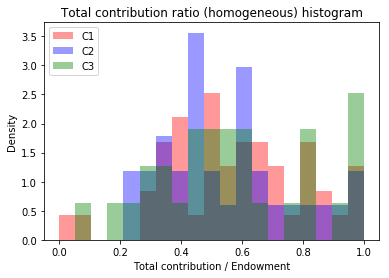

In [110]:
bins = np.linspace(0, 1, 20)

plt.hist(c1_hom['contr/budget'], bins, alpha=0.4,density = True, label='C1', color ='red')
plt.hist(c2_hom['contr/budget'], bins, alpha=0.4,density = True, label='C2', color='blue')
plt.hist(c3_hom['contr/budget'], bins, alpha=0.4,density = True, label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Density")
plt.legend(loc='upper left')
plt.title('Total contribution ratio (homogeneous) histogram')
plt.show()

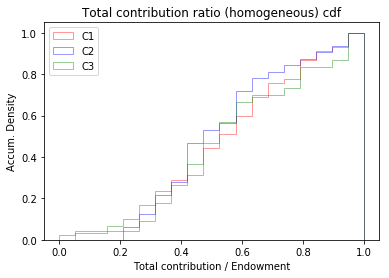

In [103]:
bins = np.linspace(0, 1, 20)

plt.hist(c1_hom['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C1', color ='red')
plt.hist(c2_hom['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C2', color='blue')
plt.hist(c3_hom['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C3', color='green')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Accum. Density")
plt.legend(loc='upper left')
plt.title('Total contribution ratio (homogeneous) cdf')
plt.show()

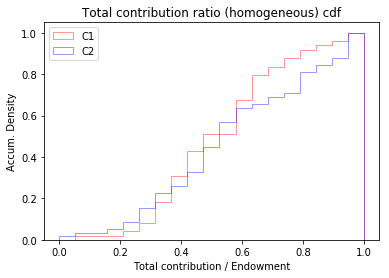

In [106]:
bins = np.linspace(0, 1, 20)

plt.hist(c1_hom['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C1', color = 'red')
plt.hist(c2_hom['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='C2', color = 'blue')
#plt.hist(c3_hom['contr/budget'], bins, alpha=0.4,density = True, cumulative=True,histtype='step', label='cluster3')
#plt.hist(categ_hom['contr/budget'], bins, alpha=0.4,density = True, label='Homogeneous')
plt.xlabel("Total contribution / Endowment")
plt.ylabel("Accum. Density")
plt.legend(loc='upper left')
plt.title('Total contribution ratio (homogeneous) cdf')
plt.show()

## Evolution of the clusters:

### A) Mean contribution of each cluster per round

#### Heterogeneous games:

In [46]:
from scipy import stats
stats.sem(heterogeneous_norm[heterogeneous_norm['clust_coef']==0].iloc[:,:10])

array([ 0.06543316,  0.06431854,  0.05529335,  0.07040253,  0.06286603,
        0.06608409,  0.06491325,  0.06369984,  0.06700303,  0.02674153])

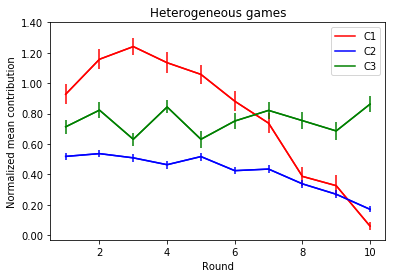

In [47]:
heterogeneous_norm['clust_coef2']=y_0_het

## Creation of new arrays: 
## a) mean contribution per round of each cluster
mean_het_c1 = heterogeneous_norm[heterogeneous_norm['clust_coef']==0].iloc[:,:10].mean(axis=0)
mean_het_c2 = heterogeneous_norm[heterogeneous_norm['clust_coef']==1].iloc[:,:10].mean(axis=0)
mean_het_c3 = heterogeneous_norm[heterogeneous_norm['clust_coef']==2].iloc[:,:10].mean(axis=0)
## b) standard deviation per round of each cluster
sigma_het_c1 = heterogeneous_norm[heterogeneous_norm['clust_coef']==0].iloc[:,:10].std(axis=0)
sigma_het_c2 = heterogeneous_norm[heterogeneous_norm['clust_coef']==1].iloc[:,:10].std(axis=0)
sigma_het_c3 = heterogeneous_norm[heterogeneous_norm['clust_coef']==2].iloc[:,:10].std(axis=0)
## c) standard error per round:
se_het_c1 = stats.sem(heterogeneous_norm[heterogeneous_norm['clust_coef']==0].iloc[:,:10])
se_het_c2 = stats.sem(heterogeneous_norm[heterogeneous_norm['clust_coef']==1].iloc[:,:10])
se_het_c3 = stats.sem(heterogeneous_norm[heterogeneous_norm['clust_coef']==2].iloc[:,:10])

#Plot
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, 10, 10)
ax.plot(x, mean_het_c1,label="C1", c = "red")
ax.errorbar(x, mean_het_c1, yerr=se_het_c1 , c = 'red')
ax.plot(x, mean_het_c2,label="C2", c = 'blue')
ax.errorbar(x, mean_het_c2, yerr=se_het_c2 , c = 'blue')
ax.plot(x, mean_het_c3,label="C3", c = 'green')
ax.errorbar(x, mean_het_c3, yerr=se_het_c3, c = 'green' )
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_ticks(np.arange(0, 1.5, 0.20))

plt.xlabel('Round')
plt.ylabel('Normalized mean contribution')
plt.title('Heterogeneous games')

plt.legend()
plt.show()

#heterogeneous_norm[heterogeneous_norm['clust_coef']==0].iloc[:,:10].mean(axis=0)

In [48]:
mean_het_c3-mean_het_c2

ronda_id
1     0.194675
2     0.286313
3     0.122125
4     0.380126
5     0.113682
6     0.326484
7     0.386327
8     0.416063
9     0.416683
10    0.692174
dtype: float64

#### Homogeneous games: 
Assumed K = 2 is the optimal number of clusters

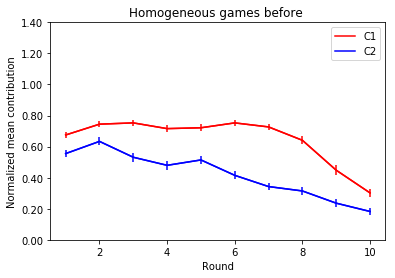

In [87]:
homogeneous_norm['clust_coef2']=y_0_hom2
homogeneous_norm['clust_coef2']= np.where(homogeneous_norm['clust_coef2'].values==1,0,1)

mean_hom_c1 = homogeneous_norm[homogeneous_norm['clust_coef2']==0].iloc[:,:10].mean(axis=0)
mean_hom_c2 = homogeneous_norm[homogeneous_norm['clust_coef2']==1].iloc[:,:10].mean(axis=0)
#mean_hom_c3 = homogeneous_norm[homogeneous_norm['clust_coef']==2].iloc[:,:10].mean(axis=0)

sigma_hom_c1 = homogeneous_norm[homogeneous_norm['clust_coef2']==0].iloc[:,:10].std(axis=0)
sigma_hom_c2 = homogeneous_norm[homogeneous_norm['clust_coef2']==1].iloc[:,:10].std(axis=0)
#sigma_hom_c3 = homogeneous_norm[homogeneous_norm['clust_coef']==2].iloc[:,:10].std(axis=0)

se_hom_c1 = stats.sem(homogeneous_norm[homogeneous_norm['clust_coef2']==0].iloc[:,:10])
se_hom_c2 = stats.sem(homogeneous_norm[homogeneous_norm['clust_coef2']==1].iloc[:,:10])

#Plot
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, 10, 10)
ax.plot(x, mean_hom_c1,label="C1", c = "red")
ax.errorbar(x, mean_hom_c1, yerr=se_hom_c1 , c = 'red')
ax.plot(x, mean_hom_c2,label="C2", c = 'blue')
ax.errorbar(x, mean_hom_c2, yerr=se_hom_c2 , c = 'blue')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_ticks(np.arange(0, 1.45, 0.20))

plt.xlabel('Round')
plt.ylabel('Normalized mean contribution')
plt.title('Homogeneous games before ')
plt.legend()
plt.show()

#heterogeneous_norm[heterogeneous_norm['clust_coef']==0].iloc[:,:10].mean(axis=0)

### Categories for each cluster: 

#### Heterogeneous:

In [113]:
#Table of frequencies of each cluster per game. 
#categ_het[categ_het['experiment']=='het_dau'].groupby(['partida_id'])['clust_coef'].value_counts().sort_index()
categ_het.groupby(['clust_coef'])['category4'].value_counts().sort_index()

clust_coef  category4
0           2            23
            3            28
1           0            12
            1            89
            2            51
2           2            34
            3            33
Name: category4, dtype: int64

In [114]:
#Table of frequencies of each cluster per game. 
#categ_het[categ_het['experiment']=='het_dau'].groupby(['partida_id'])['clust_coef'].value_counts().sort_index()
categ_het.groupby(['clust_coef'])['category'].value_counts().sort_index()

clust_coef  category
0           1            16
            2            35
1           0            29
            1           122
            2             1
2           1            20
            2            47
Name: category, dtype: int64

In [115]:
categ_het['category'].value_counts().sort_index()

0     29
1    158
2     83
Name: category, dtype: int64

#### Homogeneous:

In [30]:
categ_hom.groupby(['clust_coef'])['category'].value_counts().sort_index()

clust_coef  category
0           0            24
            1           161
            2             1
1           1            83
            2            73
Name: category, dtype: int64

In [32]:
categ_hom['category'].value_counts().sort_index().values

array([ 24, 244,  74], dtype=int64)

In [36]:
chisquare([29,158,83], f_exp=[24,244,74])

Power_divergenceResult(statistic=32.447736671097331, pvalue=8.9962912439768291e-08)

In [61]:
X = ['FR', 'FA', 'AL']
Y = categ_het['category'].value_counts().sort_index()
Y=dict(Y).values()
Z = categ_hom['category'].value_counts().sort_index()
Z=dict(Z).values()

colors = ['red', 'blue']
labels = ['Heterogeneous', 'Homogeneous']

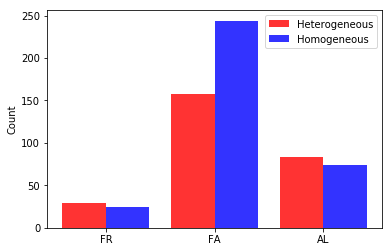

In [64]:
def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge",alpha = 0.8, color = colors[i], label = labels[i])   
    plt.xticks(_X, X)
    plt.ylabel('Count')
subcategorybar(X, [Y,Z])

plt.legend()
plt.show()

I must reject the h0 that both distributions are identical. 

### Mean contribution of each cluster:

#### Heterogeneous games:

In [100]:
## Creation of new arrays: 
## a) mean contribution per round of each cluster
mean_het_c1_u = heterogeneous[heterogeneous['clust_coef']==0].iloc[:,:10].mean(axis=1)
mean_het_c2_u = heterogeneous[heterogeneous['clust_coef']==1].iloc[:,:10].mean(axis=1)
mean_het_c3_u = heterogeneous[heterogeneous['clust_coef']==2].iloc[:,:10].mean(axis=1)
## b) standard deviation per round of each cluster
sigma_het_c1_u = heterogeneous[heterogeneous['clust_coef']==0].iloc[:,:10].std(axis=1)
sigma_het_c2_u = heterogeneous[heterogeneous['clust_coef']==1].iloc[:,:10].std(axis=1)
sigma_het_c3_u = heterogeneous[heterogeneous['clust_coef']==2].iloc[:,:10].std(axis=1)



In [101]:
## Which error?
np.mean(mean_het_c1_u)

2.2392156862745094

In [102]:
np.mean(mean_het_c2_u)

1.900657894736841

In [103]:
np.mean(mean_het_c3_u)

2.695522388059701

#### Homogeneous games:

In [90]:
## Creation of new arrays: 
## a) mean contribution per round of each cluster
mean_hom_c1_u = homogeneous_norm[homogeneous_norm['clust_coef']==0].iloc[:,:10].mean(axis=1)
mean_hom_c2_u = homogeneous_norm[homogeneous_norm['clust_coef']==1].iloc[:,:10].mean(axis=1)
#mean_het_c3_u = homogeneous_norm[homogeneous_norm['clust_coef']==2].iloc[:,:10].mean(axis=1)
## b) standard deviation per round of each cluster
sigma_hom_c1_u = homogeneous_norm[homogeneous_norm['clust_coef']==0].iloc[:,:10].std(axis=1)
sigma_hom_c2_u = homogeneous_norm[homogeneous_norm['clust_coef']==1].iloc[:,:10].std(axis=1)
#sigma_het_c3_u = homogeneous_norm[homogeneous_norm['clust_coef']==2].iloc[:,:10].std(axis=1)


In [91]:
## Which error?
np.mean(mean_hom_c1_u)

0.4413978494623657

In [92]:
np.mean(mean_hom_c2_u)

0.662339743589744

In [63]:
from scipy.stats import chisquare,ttest_ind

ttest_ind(categ_het.contr_total,categ_hom.contr_total)
## p-value > 0.05 we can not reject H0 of equal distributions. 

Ttest_indResult(statistic=-0.12038292941809448, pvalue=0.9042194527814178)

## Differences before and after the objective is fulfilled.

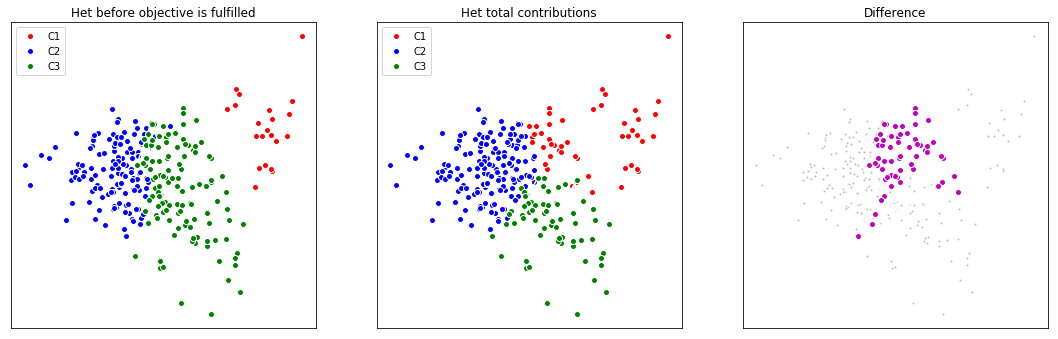

In [204]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

# #############################################################################
# Sample data

n_clusters = 3

X = heterogeneous_norm.iloc[:,:10]
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)
#
#
#X_ = pd.concat([table_het[table_het.experiment=='hetdau'].sort_index(),
#                table_het[table_het.experiment=='street'].sort_index()])
#labels, centroids, X_hat = kmeans_missing(X_.iloc[:,:10],n_clusters, max_iter=10)
#y_0_het = labels
#
## #############################################################################
# Plot result

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['red', 'blue', 'green']
labels = ['C1','C2','C3']

k_means_labels = y_het
without_means_labels = y_0_het

# KMeans
ax = fig.add_subplot(1, 3,2)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
#    cluster_center = k_means_cluster_centers[k]
    ax.plot(transformed.values[my_members, 0], transformed.values[my_members, 1], 'w',
            markerfacecolor=col, marker='o', label=labels[k])
#    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#            markeredgecolor='k', markersize=20)
ax.set_title('Het total contributions')

ax.set_xticks(())
ax.set_yticks(())
plt.legend()

# K-means without ending round: 

ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    #my_members = without_means_labels == order[k]
    my_members = without_means_labels == k
#    cluster_center = without_means_cluster_centers[order[k]]
    ax.plot(transformed.values[my_members, 0], transformed.values[my_members, 1], 'w',
            markerfacecolor=col, marker='o', label=labels[k])
#    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#            markeredgecolor='k', markersize=20)
ax.set_title('Het before objective is fulfilled')
ax.set_xticks(())
ax.set_yticks(())
plt.legend()

# Initialise the different array to all False
different = (without_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    #different += ((k_means_labels == k) != (without_means_labels == order[k]))
    different += ((k_means_labels == k) != (without_means_labels == k))

identic = np.logical_not(different)
ax.plot(transformed.values[identic, 0], transformed.values[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(transformed.values[different, 0],transformed.values[different, 1], 'w',
        markerfacecolor='m', marker='o')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

In [205]:
collections.Counter(different)

Counter({False: 210, True: 60})

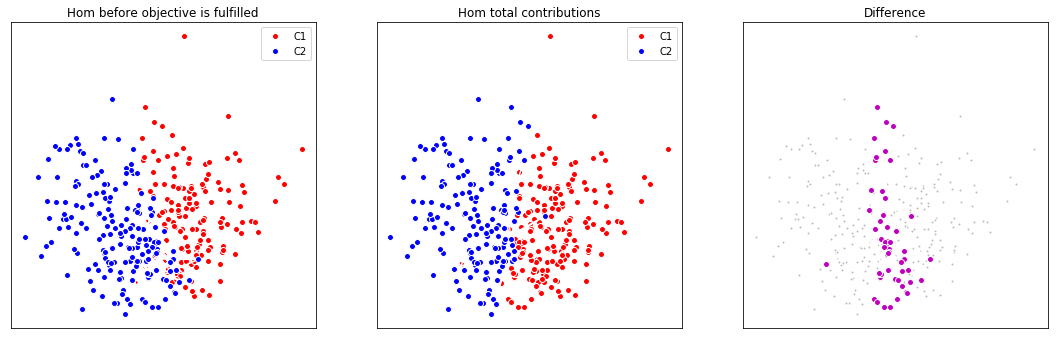

In [69]:

#n_clusters=2
X = homogeneous_norm.iloc[:,:10]
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)

###Clustering individuals without ending round contributions:
#X_ = pd.concat([table_hom[table_hom.experiment=='homdau'].sort_index(),
#                table_hom[table_hom.experiment=='vil'].sort_index()])
#labels, centroids, X_hat = kmeans_missing(X_.iloc[:,:10],n_clusters, max_iter=10)
#y_0_hom2 = labels
##canviar 0 per 1 i 1 per 0
y_0_hom2_ = np.where(y_0_hom2 == 1, 0, 1)


## #############################################################################
# Plot result

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['red', 'blue']
labels = ['C1','C2']

k_means_labels = y_hom2
without_means_labels = y_0_hom2

# KMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
#    cluster_center = k_means_cluster_centers[k]
    ax.plot(transformed.values[my_members, 0], transformed.values[my_members, 1], 'w',
            markerfacecolor=col, marker='o', label= labels[k])
#    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#            markeredgecolor='k', markersize=20)
ax.set_title('Hom total contributions')
ax.set_xticks(())
ax.set_yticks(())
plt.legend()

# K-means without ending round: 

ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    #my_members = without_means_labels == order[k]
    my_members = without_means_labels == k
#    cluster_center = without_means_cluster_centers[order[k]]
    ax.plot(transformed.values[my_members, 0], transformed.values[my_members, 1], 'w',
            markerfacecolor=col, marker='o', label= labels[k])
#    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#            markeredgecolor='k', markersize=20)
ax.set_title('Hom before objective is fulfilled')
ax.set_xticks(())
ax.set_yticks(())
plt.legend()

# Initialise the different array to all False
different = (without_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    #different += ((k_means_labels == k) != (without_means_labels == order[k]))
    different += ((k_means_labels == k) != (without_means_labels == k))

identic = np.logical_not(different)
ax.plot(transformed.values[identic, 0], transformed.values[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(transformed.values[different, 0],transformed.values[different, 1], 'w',
        markerfacecolor='m', marker='o')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

In [208]:
collections.Counter(different)

Counter({False: 289, True: 53})

In [226]:
categ_het['clust_coef2']=y_0_het

In [42]:
X = heterogeneous_norm.iloc[:,:10]
clust1_het_b = X.iloc[y_0_het == 0]
clust2_het_b = X.iloc[y_0_het == 1]
clust3_het_b = X.iloc[y_0_het == 2]

In [43]:
mean_contr_clust1 = clust1_het_b.iloc[:,:10].mean(axis=1)
print('Mean contribution cluster 1 b',np.mean(mean_contr_clust1))
print('SE cluster 1 b', stats.sem(mean_contr_clust1))

mean_contr_clust2 = clust2_het_b.iloc[:,:10].mean(axis=1)
print('Mean contribution cluster 3 b',np.mean(mean_contr_clust2))
print('SE cluster 2 b', stats.sem(mean_contr_clust2))

mean_contr_clust3 = clust3_het_b.iloc[:,:10].mean(axis=1)
print('Mean contribution cluster 3 b',np.mean(mean_contr_clust3))
print('SE cluster 3 b', stats.sem(mean_contr_clust3))

Mean contribution cluster 1 b 0.953787878787879
SE cluster 1 b 0.0167720986363
Mean contribution cluster 3 b 0.39433593749999984
SE cluster 2 b 0.0102250308672
Mean contribution cluster 3 b 0.6886666666666665
SE cluster 3 b 0.0129043320824
